## Colab Setup

In [39]:
# mounting and connecting with drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Setup colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [41]:
# importing train file from gdrive
link = 'https://drive.google.com/open?id=1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') # file will be stored as train.csv in the colab directory

1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee


In [42]:
# importing labels file from gdrive
link = 'https://drive.google.com/open?id=1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labels.json')

1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr


In [0]:
# importing libraries
import os
import gc
import sys
import math
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

import tensorflow as tf

In [0]:
# setting up path directory
ROOT_DIR = Path('/content/')
DATA_DIR = Path('/content/drive/My Drive/Projects/iMaterialist/')
TRAIN_IMAGE_DIR = Path('/content/drive/My Drive/Medium_7K_train/')
TEST_DIR = Path('/content/drive/My Drive/Medium_4K train/')

## Data Setup

In [45]:
# import train file 
import pandas as pd
train = pd.read_csv('train.csv')
train.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [0]:
# extracting image metadata fom json file 
with open(ROOT_DIR/"labels.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [47]:
label_df = pd.DataFrame(label_names).reset_index()
label_df.columns = ['Id','Labels']
label_df[0:12]

,Id,Labels
0,0,"shirt, blouse"
1,1,"top, t-shirt, sweatshirt"
2,2,sweater
3,3,cardigan
4,4,jacket
5,5,vest
6,6,pants
7,7,shorts
8,8,skirt
9,9,coat


In [48]:
segment_df = train
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  333415


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [49]:
error_analysis1 = pd.read_csv('/content/drive/My Drive/Projects/iMaterialist/trained weights/error_analysis1.csv')
error_analysis1.head()

,Unnamed: 0,Count Missed,Label Id,Labels,Count Correct,missed %,total labels
0,35,65,31,sleeve,2566.0,2.470544,2631.0
1,31,79,23,shoe,2040.0,3.728174,2119.0
2,19,125,6,pants,1037.0,10.757315,1162.0
3,2,568,33,neckline,2409.0,19.079610,2977.0
4,5,334,10,dress,1308.0,20.341048,1642.0


In [50]:
subset_labels = error_analysis1[error_analysis1['missed %']>35].loc[:,['Label Id','Labels','missed %']]
subset_labels.head()

,Label Id,Labels,missed %
8,14,hat,38.211382
9,4,jacket,39.389535
10,1,"top, t-shirt, sweatshirt",39.496941
11,7,shorts,44.588745
12,18,watch,45.962733


In [0]:
segment_df['CategoryId'] = segment_df['CategoryId'].astype(int)

In [52]:
# subset the images for labels we want to train on 
segment_df = segment_df.merge(subset_labels,how='inner', left_on = 'CategoryId',right_on='Label Id')
segment_df.shape

(103388, 9)

In [53]:
# Rows with the same image are grouped together because the subsequent operations perform at an image level
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  34458


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6323163 11 6328356 32 6333549 53 6338742 75 6...,"[0, 32, 32, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[1343707 9 1346138 27 1348569 44 1351000 62 13...,[1],2448,2448
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[133262 2 133826 4 134390 6 134956 7 135522 7 ...,[15],567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[192100 1 192849 4 193598 4 194347 4 195097 4 ...,[15],750,500
00048c3a2fb9c29340473c4cfc06424a.jpg,[257702 10 258670 26 259640 36 260572 6 260610...,"[1, 8, 35, 24]",975,650


In [0]:
# Since we are training on subset of images

images = os.listdir(TRAIN_IMAGE_DIR)
uploaded_images = pd.DataFrame(images, columns = ['image_name'])
image_df = image_df[image_df.index.isin(uploaded_images['image_name'])]

In [0]:
# Partition data in train and test
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

## Setting up Mask RCNN

In [56]:
# import matterport Mask-RCNN implementation
!git clone https://www.github.com/matterport/Mask_RCNN.git;
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 43.73 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [0]:
# Already have trained weights, we will continue on those weights
pre_trained_weight = '/content/drive/My Drive/Projects/iMaterialist/trained weights/weights_0.08133.h5'

In [58]:
# Set configuration

NUM_CATS = 46 # subset_labels['Label Id'].nunique()  # classification ignoring attributes (only categories)
IMAGE_SIZE = 512 # the image size is set to 512, which is the same as the size of submission masks

class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # Batch size
    
    BACKBONE = 'resnet50' #maybe try resnet 101 too, resnet 101 might give better results
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = "none"
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 100

    MAX_GT_INSTANCES = 50
    DETECTION_MAX_INSTANCES = 50

    LOSS_WEIGHTS = {
          "rpn_class_loss": 10.0, # How well the Region Proposal Network separates background with objetcs
          "rpn_bbox_loss": 0.8, # How well the RPN localize objects
          "mrcnn_class_loss": 6.0, # How well the Mask RCNN localize objects
          "mrcnn_bbox_loss": 6.0, # How well the Mask RCNN recognize each class of object
          "mrcnn_mask_loss": 6.0 # How well the Mask RCNN segment objects
    }
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 10.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 6.0, 'mrcnn_mask_loss': 6.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [0]:
# custom function to resize an image, we are resizing image to 512X512; suitable for submission
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [0]:
#  MaskRCNN Class

class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(TRAIN_IMAGE_DIR/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/content/drive/My Drive/Medium_7K_train/72ee179d4356aeaea73dd59849fb9132.jpg', ['bag, wallet', 'belt', 'buckle'])


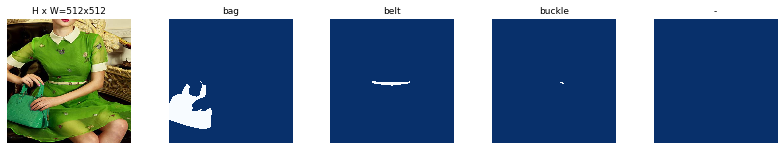

('/content/drive/My Drive/Medium_7K_train/0624b7e0b71d638702de11c9fe168662.jpg', ['jacket', 'top, t-shirt, sweatshirt', 'shorts'])


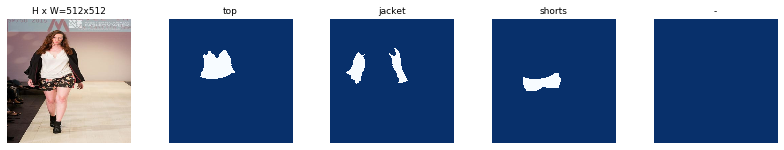

('/content/drive/My Drive/Medium_7K_train/69aed9030ff7e61aeaa161b935cce2ab.jpg', ['pocket', 'pocket', 'top, t-shirt, sweatshirt', 'shorts'])


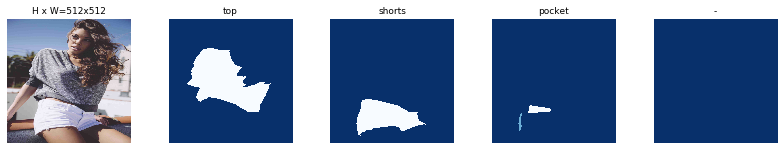

In [61]:
# Visualizing random images
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(3):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [0]:
# Prepare Data
train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

## Training

In [0]:
# Image augmentation
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.3)),
        iaa.Sharpen(alpha=(0.0, 0.3)),
    ]),
])

In [0]:
# create a Mask R-CNN model and specifies augmentations to be used.

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR);
model.load_weights(pre_trained_weight, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
# Declaring learning rate
LR = 0.0001

In [0]:
# First, we train only the heads. train heads with higher lr to speedup the learning

%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*4,
            epochs=5,
            layers='heads')
history = model.keras_model.history.history
history


Starting at epoch 0. LR=0.0004

Checkpoint Path: /content/fashion20191123T0820/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
1000/1000 [==============================] - 1080s 1s/step - loss: 8.6586 - rpn_class_loss: 0.3795 - rpn_bbox_loss: 1.7774 - mrcnn_class_loss: 1.5058 - mrcnn_bbox_loss: 2.4142 - mrcnn_mask_loss: 2.5817 - val_loss: 6.9946 - val_rpn_class_loss: 0.2910 - val_rpn_bbox_loss: 1.9882 - val_mrcnn_class_loss: 0.7048 - val_mrcnn_bbox_loss: 2.0009 - val_mrcnn_mask_loss: 2.0096

Epoch 2/5
1000/1000 [==============================] - 950s 950ms/step - loss: 6.7573 - rpn_class_loss: 0.3615 - rpn_bbox_loss: 1.7263 - mrcnn_class_loss: 0.9415 - mrcnn_bbox_loss: 1.7784 - mrcnn_mask_loss: 1.9496 - val_loss: 7.4612 - val_rpn_class_loss: 0.4605 - val_rpn_bbox_loss: 1.9239 - val_mrcnn_class_loss: 1.2320 - val_mrcnn_bbox_loss: 1.7868 - val_mrcnn_mask_loss: 2.0580
Epoch 3/5
1000/1000 [==============================] - 1008s 1s/step - loss: 6.3691 - rpn_class_loss: 0.3257 - rpn_bbox_loss: 1.5399 - mrcnn_class_loss: 0.9663 - mrcnn_bbox_loss: 1.6819 - mrcnn_mask_loss: 1.8552 - val_loss: 6.2183 - val_

In [0]:
#reduce LR and train again.

%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=10,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 5. LR=0.0001

Checkpoint Path: /content/fashion20191123T0820/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 6/10
1000/1000 [==============================] - 788s 788ms/step - loss: 6.7335 - rpn_class_loss: 0.3345 - rpn_bbox_loss: 1.4834 - mrcnn_class_loss: 1.0571 - mrcnn_bbox_loss: 1.8461 - mrcnn_mask_loss: 2.0125 - val_loss: 5.7647 - val_rpn_class_loss: 0.2681 - val_rpn_bbox_loss: 1.3528 - val_mrcnn_class_loss: 0.7556 - val_mrcnn_bbox_loss: 1.5495 - val_mrcnn_mask_loss: 1.8387
Epoch 7/10
1000/1000 [==============================] - 693s 693ms/step - loss: 6.2745 - rpn_class_loss: 0.3271 - rpn_bbox_loss: 1.5363 - mrcnn_class_loss: 0.9038 - mrcnn_bbox_loss: 1.6482 - mrcnn_mask_loss: 1.8592 - val_loss: 6.5666 - val_rpn_class_loss: 0.4430 - val_rpn_bbox_loss: 1.9432 - val_mrcnn_class_loss: 0.9251 - val_mrcnn_bbox_loss: 1.4282 - val_mrcnn_mask_loss: 1.8272
Epoch 8/10
1000/1000 [==============================] - 692s 692ms/step - loss: 6.0806 - rpn_class_loss: 0.3335 - rpn_bbox_loss: 1.5092 - mrcnn_class_loss: 0.9036 - mrcnn_bbox_loss: 1.5340 - mrcnn_mask_loss: 1.8003 - val_loss: 5.6740 - 

In [0]:
#reduce LR and train again.

%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/8,
            epochs=20,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 10. LR=2.5e-05

Checkpoint Path: /content/fashion20191123T0820/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 11/20
1000/1000 [==============================] - 778s 778ms/step - loss: 5.8539 - rpn_class_loss: 0.2938 - rpn_bbox_loss: 1.3595 - mrcnn_class_loss: 0.8897 - mrcnn_bbox_loss: 1.4752 - mrcnn_mask_loss: 1.8356 - val_loss: 5.7602 - val_rpn_class_loss: 0.2690 - val_rpn_bbox_loss: 1.4216 - val_mrcnn_class_loss: 0.7086 - val_mrcnn_bbox_loss: 1.5374 - val_mrcnn_mask_loss: 1.8235
Epoch 12/20
1000/1000 [==============================] - 693s 693ms/step - loss: 5.6590 - rpn_class_loss: 0.2915 - rpn_bbox_loss: 1.3700 - mrcnn_class_loss: 0.8115 - mrcnn_bbox_loss: 1.4356 - mrcnn_mask_loss: 1.7503 - val_loss: 6.3757 - val_rpn_class_loss: 0.4342 - val_rpn_bbox_loss: 1.9105 - val_mrcnn_class_loss: 0.8651 - val_mrcnn_bbox_loss: 1.4069 - val_mrcnn_mask_loss: 1.7590
Epoch 13/20
1000/1000 [==============================] - 695s 695ms/step - loss: 5.5263 - rpn_class_loss: 0.2967 - rpn_bbox_loss: 1.3586 - mrcnn_class_loss: 0.8173 - mrcnn_bbox_loss: 1.3524 - mrcnn_mask_loss: 1.7013 - val_loss: 5.5895

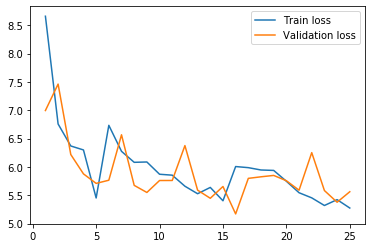

In [0]:
epochs = range(1, len(history['loss'])+1)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.legend()

In [0]:
# find best epoch
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  16
Valid loss:  5.170043992996216


In [0]:
# Picking the location of our best model weights
glob_list = glob.glob(f'/content/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

In [0]:
model_path

'/content/fashion20191123T0820/mask_rcnn_fashion_0016.h5'

## Prediction

In [0]:
# Prediction, this cell defines InferenceConfig and loads the best trained model.

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', config=inference_config,model_dir=ROOT_DIR)

model.load_weights(model_path, by_name=True)

Re-starting from epoch 16


In [0]:
# refine overlapped mask
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [0]:
segment_df2 = train
segment_df2['CategoryId'] = segment_df2['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df2))
segment_df2.head()

Total segments:  333415


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [0]:
# Rows with the same image are grouped together because the subsequent operations perform at an image level
image_df2 = segment_df2.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df2 = segment_df2.groupby('ImageId')['Height', 'Width'].mean()
image_df2 = image_df2.join(size_df2, on='ImageId')

print("Total images: ", len(image_df2))
image_df2.head()

Total images:  45625


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [0]:
# We will test on 4k images, subsetting data for that

images = os.listdir(TEST_DIR)
uploaded_images = pd.DataFrame(images, columns = ['image_name'])
image_df2 = image_df2[image_df2.index.isin(uploaded_images['image_name'])]
len(image_df2)

4103

In [0]:
# refine overlapped mask
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [0]:
pred_file = image_df2.reset_index().iloc[:,:3]
pred_file.head()

,ImageId,EncodedPixels,CategoryId
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]"
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]"
2,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]"
3,000aac3870ea7c59ca0333ffa5327323.jpg,[8971124 17 8975101 49 8979077 82 8983053 116 ...,"[10, 33, 3, 31, 31, 33]"
4,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,[291578 3 292856 8 294133 13 295410 19 296687 ...,"[10, 33, 24]"


In [0]:
pred_file.shape

(4103, 3)

In [0]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [0]:
# Run prediction on test
%%time
test_path = TEST_DIR
sub_list = []
missing_count = 0
for i, row in tqdm(pred_file.iterrows(), total=len(pred_file)):
    image = resize_image(str(test_path/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

100%|██████████| 4103/4103 [1:00:01<00:00,  1.16it/s]

CPU times: user 22min 35s, sys: 14min 45s, total: 37min 21s
Wall time: 1h 1s


In [0]:
# save predicted data in submission file to upload in Kaggle
pred_df = pd.DataFrame(sub_list, columns=pred_file.columns.values)
print("Total image results: ", pred_df['ImageId'].nunique())
print("Missing Images: ", missing_count)

pred_df.head()

Total image results:  4103
Missing Images:  256


,ImageId,EncodedPixels,CategoryId
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,60845 10 61351 20 61858 28 62364 37 62868 48 6...,1
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,102655 13 103161 29 103669 38 104178 53 104687...,8
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,103159 2 103190 3 103668 1 103707 4 104177 1 1...,1
3,0002ec21ddb8477e98b2cbb87ea2e269.jpg,152440 12 152949 15 153457 19 153966 22 154475...,8
4,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,117895 26 118401 35 118904 44 119415 45 119926...,1


In [0]:
pred_df['CategoryId'].value_counts()

1     2775
32    1955
8     1493
24     930
19     652
14     607
4      570
18     509
0      475
9      409
7      284
15     259
23     256
34      34
35       1
Name: CategoryId, dtype: int64

In [0]:
pred_df.to_csv('pred_df_sampled.csv')

In [0]:
normal_predict = pd.read_csv('/content/pred_df.csv') 

In [0]:
normal_predict = normal_predict[~normal_predict['CategoryId'].isin([1,4,14])].reset_index()
normal_predict.drop(columns = ['index','Unnamed: 0'], inplace = True)

In [0]:
normal_predict.head()

,ImageId,EncodedPixels,CategoryId
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,102498 4 103010 5 103522 6 104036 5 104549 5 1...,33
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,173885 26 174395 30 174463 2 174719 11 174906 ...,31
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,135642 12 136150 18 136662 19 137185 9 137698 ...,23
3,0002ec21ddb8477e98b2cbb87ea2e269.jpg,118208 2 118716 10 119227 12 119737 15 120248 ...,23
4,0002ec21ddb8477e98b2cbb87ea2e269.jpg,102659 25 103166 34 103673 50 104179 70 104686...,10


In [0]:
sampled_predict = pred_df[pred_df['CategoryId'].isin([1,4,14])].reset_index(drop = True)
sampled_predict.head()

,ImageId,EncodedPixels,CategoryId
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,60845 10 61351 20 61858 28 62364 37 62868 48 6...,1
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,103159 2 103190 3 103668 1 103707 4 104177 1 1...,1
2,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,117895 26 118401 35 118904 44 119415 45 119926...,1
3,000aac3870ea7c59ca0333ffa5327323.jpg,114432 6 114941 10 115450 13 115957 18 116466 ...,1
4,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,93835 6 94345 9 94856 12 95368 13 95879 16 963...,1


In [0]:
normal_predict.shape, sampled_predict.shape

((26426, 3), (3952, 3))

In [0]:
new_pred = pd.concat([normal_predict,sampled_predict],ignore_index=True).drop_duplicates().reset_index(drop=True)

In [0]:
new_pred.to_csv('combined_pred.csv')

In [0]:
# Rows with the same image grouped together
new_pred = new_pred.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
new_pred.head()

,EncodedPixels,CategoryId
ImageId,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,[102498 4 103010 5 103522 6 104036 5 104549 5 ...,"[33, 31, 1]"
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[135642 12 136150 18 136662 19 137185 9 137698...,"[23, 23, 10, 33, 1]"
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[4544 4 5053 10 5563 13 6073 16 6582 21 7091 2...,"[10, 33, 33, 37, 1]"
000aac3870ea7c59ca0333ffa5327323.jpg,[95481 11 95982 30 96482 47 96989 55 97495 63 ...,"[31, 33, 10, 33, 1]"
000b3a87508b0fa185fbd53ecbe2e4c6.jpg,[141205 6 141715 10 142226 12 142736 15 143246...,"[24, 33, 10, 19, 13, 21, 21, 1]"


In [0]:
image_df2.head()

,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
000aac3870ea7c59ca0333ffa5327323.jpg,[8971124 17 8975101 49 8979077 82 8983053 116 ...,"[10, 33, 3, 31, 31, 33]",4000,6000
000b3a87508b0fa185fbd53ecbe2e4c6.jpg,[291578 3 292856 8 294133 13 295410 19 296687 ...,"[10, 33, 24]",1280,852


In [0]:
new_pred.shape, image_df2.shape

((4103, 2), (4103, 4))

In [0]:
combine_df = image_df2.reset_index().merge(new_pred.reset_index(), how='inner', left_on='ImageId', right_on='ImageId').loc[:,['ImageId','CategoryId_x','CategoryId_y']]

In [0]:
combine_df.columns = ['ImageId','Truth','Prediction']
combine_df.head()

,ImageId,Truth,Prediction
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,"[33, 1]","[33, 31, 1]"
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,"[33, 10, 23, 23]","[23, 23, 10, 33, 1]"
2,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,"[10, 33, 15]","[10, 33, 33, 37, 1]"
3,000aac3870ea7c59ca0333ffa5327323.jpg,"[10, 33, 3, 31, 31, 33]","[31, 33, 10, 33, 1]"
4,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,"[10, 33, 24]","[24, 33, 10, 19, 13, 21, 21, 1]"


In [0]:
combine_df['Truth'] = combine_df['Truth'].map(lambda x:[int(y) for y in x])

In [0]:
combine_df['correct']= combine_df['Truth']
combine_df['missed']= combine_df['Truth']
combine_df['extra']= combine_df['Truth']

for i in range(len(combine_df)):
  combine_df.loc[i,'correct'] = (list(set(combine_df.iloc[i,1]).intersection(combine_df.iloc[i,2])))
  combine_df.loc[i,'missed'] = (list(set(combine_df.iloc[i,1]) - set(combine_df.iloc[i,2])))
  combine_df.loc[i,'extra'] = (list(set(combine_df.iloc[i,2]) - set(combine_df.iloc[i,1])))

combine_df.head()

,ImageId,Truth,Prediction,correct,missed,extra
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,"[33, 1]","[33, 31, 1]","[33, 1]",[],[31]
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,"[33, 10, 23, 23]","[23, 23, 10, 33, 1]","[33, 10, 23]",[],[1]
2,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,"[10, 33, 15]","[10, 33, 33, 37, 1]","[33, 10]",[15],"[1, 37]"
3,000aac3870ea7c59ca0333ffa5327323.jpg,"[10, 33, 3, 31, 31, 33]","[31, 33, 10, 33, 1]","[33, 10, 31]",[3],[1]
4,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,"[10, 33, 24]","[24, 33, 10, 19, 13, 21, 21, 1]","[24, 33, 10]",[],"[1, 21, 19, 13]"


In [0]:
correct_list = []
missed_list = []
extra_list = []

for i in range(len(combine_df)):
  correct_list.extend(combine_df.iloc[i,3])
  missed_list.extend(combine_df.iloc[i,4])
  extra_list.extend(combine_df.iloc[i,5])

In [0]:
label_df = pd.DataFrame(label_names).reset_index()
label_df.columns = ['Id','Labels']
label_df.head()

,Id,Labels
0,0,"shirt, blouse"
1,1,"top, t-shirt, sweatshirt"
2,2,sweater
3,3,cardigan
4,4,jacket


In [0]:
from collections import Counter
correct_df = pd.DataFrame.from_dict(Counter(correct_list), orient='index').reset_index().sort_values(by = 0, ascending = False)\
                        .merge(label_df, left_on = 'index', right_on='Id').loc[:,[0,'Labels']]
correct_df.columns = ['Count Correct','Labels']
correct_df.head(10)

,Count Correct,Labels
0,2566,sleeve
1,2409,neckline
2,2040,shoe
3,1308,dress
4,1045,"top, t-shirt, sweatshirt"
5,1037,pants
6,605,pocket
7,565,collar
8,394,jacket
9,366,lapel


In [0]:
missed_df = pd.DataFrame.from_dict(Counter(missed_list), orient='index').reset_index().sort_values(by = 0, ascending = False)\
                        .merge(label_df, left_on = 'index', right_on='Id').loc[:,[0,'Id','Labels']]
missed_df.columns = ['Count Missed','Label Id','Labels']
missed_df.head()

,Count Missed,Label Id,Labels
0,609,32,pocket
1,568,33,neckline
2,469,0,"shirt, blouse"
3,426,1,"top, t-shirt, sweatshirt"
4,411,19,belt


In [0]:
extra_df = pd.DataFrame.from_dict(Counter(extra_list), orient='index').reset_index().sort_values(by = 0, ascending = False)\
                        .merge(label_df, left_on = 'index', right_on='Id').loc[:,[0,'Labels']]
extra_df.columns = ['Count Extra','Labels']
extra_df.head()

,Count Extra,Labels
0,1474,"top, t-shirt, sweatshirt"
1,701,sleeve
2,422,pants
3,420,hat
4,356,dress


In [0]:
error_analysis = missed_df.merge(correct_df, how = 'left', on='Labels').fillna(0)

In [0]:
error_analysis['missed %'] = (error_analysis['Count Missed']*100)/(error_analysis['Count Missed']+error_analysis['Count Correct'])
error_analysis['total labels'] = (error_analysis['Count Missed']+error_analysis['Count Correct'])

In [0]:
error_analysis1 = error_analysis[error_analysis['total labels']>200].sort_values(by ='missed %')

In [0]:
error_analysis1.to_csv('ravi_error.csv')